In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import methods
from importlib import reload

/tmp/ipykernel_2578/400164470.py:4: RuntimeWarning: invalid value encountered in true_divide
  input_cl /= ell_input*(ell_input+1)/2/np.pi


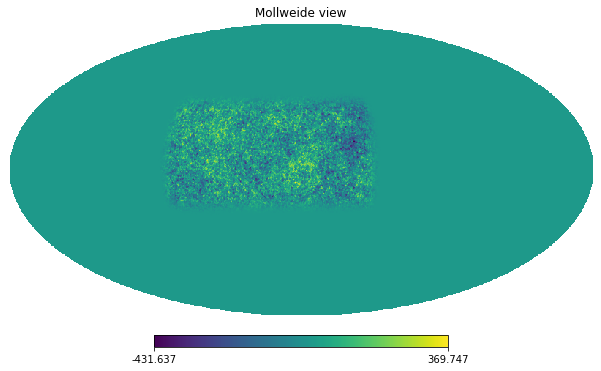

In [2]:
reload(methods)
ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
input_cl = np.array([TT, TE, EE, BB])
input_cl /= ell_input*(ell_input+1)/2/np.pi 
for c in input_cl: c[0] = 0

nside = 128
lmax = 3*nside-1
npix = 12*nside**2
pixels_lr, pixels_ud = methods.create_pixels()
rate = 10 #hz

TT = input_cl[0]
input_map = hp.synfast(TT, nside)
mask = np.zeros(npix)
mask[pixels_lr] = 1
mask_apo = nmt.mask_apodization(mask, 2.5, apotype="Smooth")    
hp.mollview(mask_apo * input_map)

/scratch/yuyang/destripe/methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  output_map = PT(filtered_tod, pixels, npix)/PTP(pixels, npix)
/scratch/yuyang/destripe/methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  output_map = PT(filtered_tod, pixels, npix)/PTP(pixels, npix)


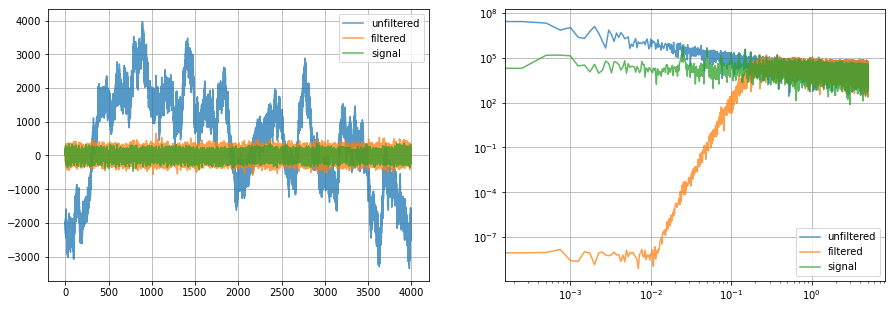

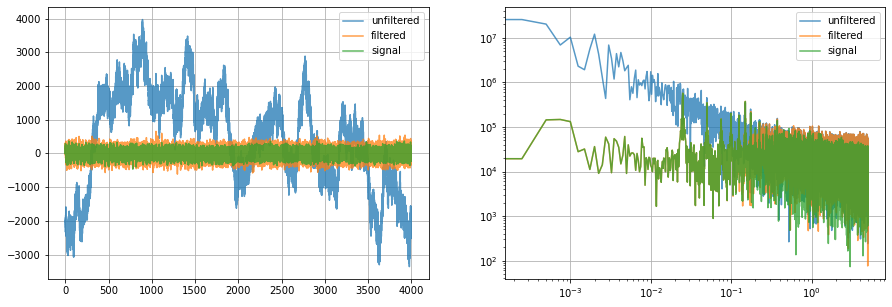

In [3]:
#Quick demo of replace=False vs True
reload(methods)
output_map1 = methods.map2map(input_map, pixels_lr, rate, noise_params=(0.5,2,100,0), subscan_poly_deg=10, plot=True, replace=False)
output_map2 = methods.map2map(input_map, pixels_lr, rate, noise_params=(0.5,2,100,0), subscan_poly_deg=10, plot=True, replace=True)

In [4]:
# reload(methods)
# ells, cl_fb = methods.sim_cl2cl(TT, (pixels_lr, pixels_ud), rate, n_sims=10, n_obs=10, replace=False)
# ells, cl_ft = methods.sim_cl2cl(np.ones(lmax+1), (pixels_lr, pixels_ud), rate, n_sims=10, n_obs=10, noise_params=None, replace=False)
# ells, cl_replace = methods.sim_cl2cl(TT, (pixels_lr, pixels_ud), rate, n_sims=10, n_obs=10, replace=True)

100%|███████████████████████████████████████████| 10/10 [01:17<00:00,  7.77s/it]


In [5]:
ells = np.load('ells.npy')
cl_fb = np.load('cl_fb.npy')
cl_ft = np.load('cl_ft.npy')
cl_replace = np.load('cl_replace.npy')

In [6]:
ft_l, ft_m, ft_h = np.percentile(cl_ft, [2.5,50,97.5], axis=0) #68% confidence interval
fb_l, fb_m, fb_h = np.percentile(cl_fb, [2.5,50,97.5], axis=0) 
replace_l, replace_m, replace_h = np.percentile(cl_replace, [2.5,50,97.5], axis=0) 

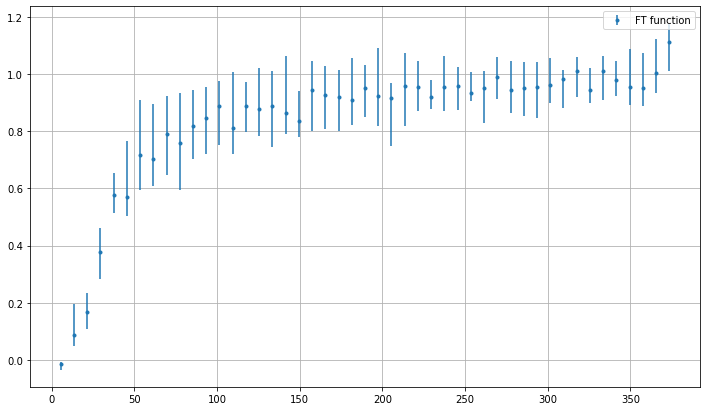

In [7]:
plt.figure(figsize=(12,7))
plt.errorbar(ells, ft_m, (ft_m-ft_l,ft_h-ft_m), fmt='.', label='FT function')
plt.grid()
plt.legend()

In [8]:
#Divide out FT with MC
rng = np.random.default_rng()

fbc_m = np.zeros_like(fb_m)
fbc_l = np.zeros_like(fb_l)
fbc_h = np.zeros_like(fb_h)

for i in range(len(ells)):
    cl_fbc = [cl_fb[:,i][rng.integers(0, cl_ft.shape[0])] / cl_ft[:,i][rng.integers(0, cl_ft.shape[0])] for j in range(1000)]
    l, m, h = np.percentile(cl_fbc, [2.5,50,97.5]) 
    fbc_l[i] = l
    fbc_m[i] = m
    fbc_h[i] = h

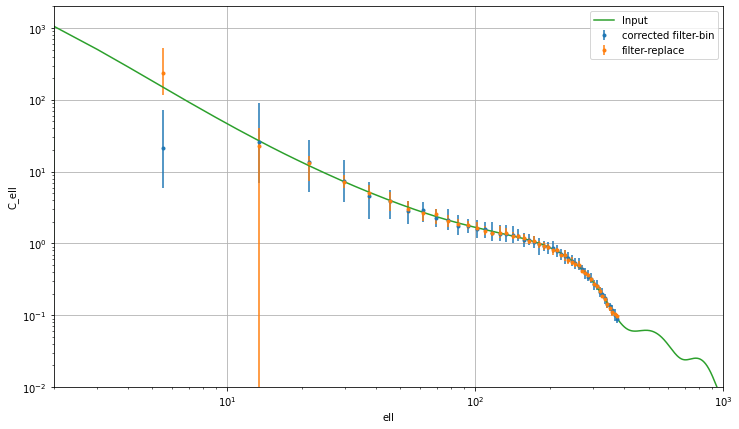

In [9]:
plt.figure(figsize=(12,7))
# plt.errorbar(ells, fb_m, (fb_m-fb_l,fb_h-fb_m), fmt='.', label='uncorrected filter-bin')
plt.errorbar(ells, fbc_m, (fbc_m-fbc_l,fbc_h-fbc_m), fmt='.', label='corrected filter-bin')
plt.errorbar(ells, replace_m, (replace_m-replace_l,replace_h-replace_m), fmt='.', label='filter-replace')
plt.plot(ell_input, TT, label='Input')
plt.loglog()
plt.xlim([2e0,1e3])
plt.ylim([1e-2,2e3])
plt.ylabel('C_ell')
plt.xlabel('ell')
plt.legend()
plt.grid()    

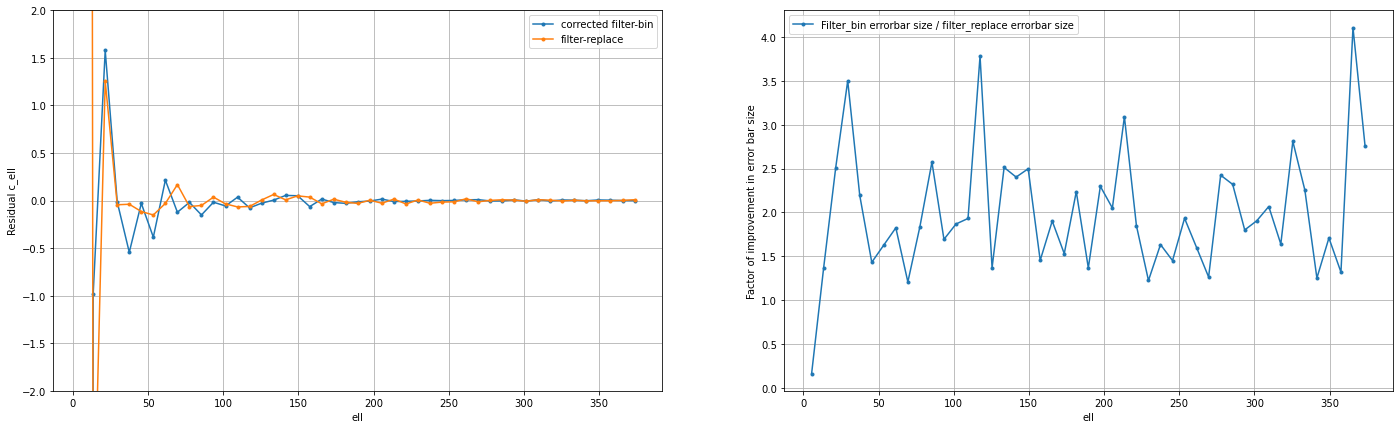

In [10]:
interp_input = np.interp(ells, ell_input, TT)

fig, axes = plt.subplots(1,2, figsize=(24, 7))
axes[0].plot(ells, fbc_m - interp_input , marker='.', label='corrected filter-bin')
axes[0].plot(ells, replace_m - interp_input, marker='.', label='filter-replace')
axes[0].set_ylabel('Residual c_ell')
axes[0].set_ylim([-2, 2])

axes[1].plot(ells, (fbc_h-fbc_l)/(replace_h-replace_l), marker='.', label='Filter_bin errorbar size / filter_replace errorbar size')
axes[1].set_ylabel('Factor of improvement in error bar size')
# axes[1].set_ylim([0,12])

for ax in axes:
    ax.grid()
    ax.legend()
    ax.set_xlabel('ell')